## Aggregate 1 min grids into a time series and accumulate in time

This notebook demonstrates some utility functions in glmtools.io.imagery that:

1. aggregate 1 min GLM data files into a time series dataset
2. accumulate the 1 min files over an arbitrary length, correctly calculating the average and minimum quantities.

You will need to adjust the file paths and number of minutes over which to accumulate.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import dask

# This will automatically use multiple cores to perform the computation over datasets that don't fit in memory
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57698 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [2]:
import os
from glmtools.io.imagery import open_glm_time_series, aggregate

In [3]:
# ls /data/LCFA-production/GLM-L2-LCFA_G16_s201905_tests/slowdown/2018Mar07/2018/Mar/07/

In [4]:
fns = [os.path.join('/data/LCFA-production/GLM-L2-LCFA_G16_s201905_tests/slowdown/2018Mar07/2018/Mar/07/', fn)
                    for fn in 
                    ('OR_GLM-L2-GLMF-M3_G16_s20180660440000_e20180660441000_c20192232103080.nc',
                     'OR_GLM-L2-GLMF-M3_G16_s20180660441000_e20180660442000_c20192232103540.nc',
                     'OR_GLM-L2-GLMF-M3_G16_s20180660442000_e20180660443000_c20192232104470.nc',
                    )
      ]

accum_mins = 3

glm = open_glm_time_series(fns)
print(glm)

# accumulate over 3 minutes. To also subset a long dataset, see the start_end kwarg
agglm = aggregate(glm, accum_mins)
# Set the time coordinate to the start time of each time bin (could also choose mid)
agglm['time_bins'] = [v.left for v in agglm.time_bins.values]
glm_grids = agglm.rename({'time_bins':'time'})
print(glm_grids)

<xarray.Dataset>
Dimensions:                         (time: 3, x: 5424, y: 5424)
Coordinates:
  * x                               (x) float32 -0.151844 -0.151788 ... 0.151844
  * y                               (y) float32 0.151844 0.151788 ... -0.151844
  * time                            (time) datetime64[ns] 2018-03-07T04:40:00 ... 2018-03-07T04:42:00
Data variables:
    goes_imager_projection          (time) int32 -2147483647 ... -2147483647
    DQF                             (time, y, x) float32 dask.array<shape=(3, 5424, 5424), chunksize=(1, 5424, 5424)>
    nominal_satellite_subpoint_lat  (time) float64 0.0 0.0 0.0
    nominal_satellite_subpoint_lon  (time) float64 -75.0 -75.0 -75.0
    flash_extent_density            (time, y, x) float32 dask.array<shape=(3, 5424, 5424), chunksize=(1, 5424, 5424)>
    flash_centroid_density          (time, y, x) float32 dask.array<shape=(3, 5424, 5424), chunksize=(1, 5424, 5424)>
    average_flash_area              (time, y, x) float32 dask.ar

<IPython.core.display.Javascript object>


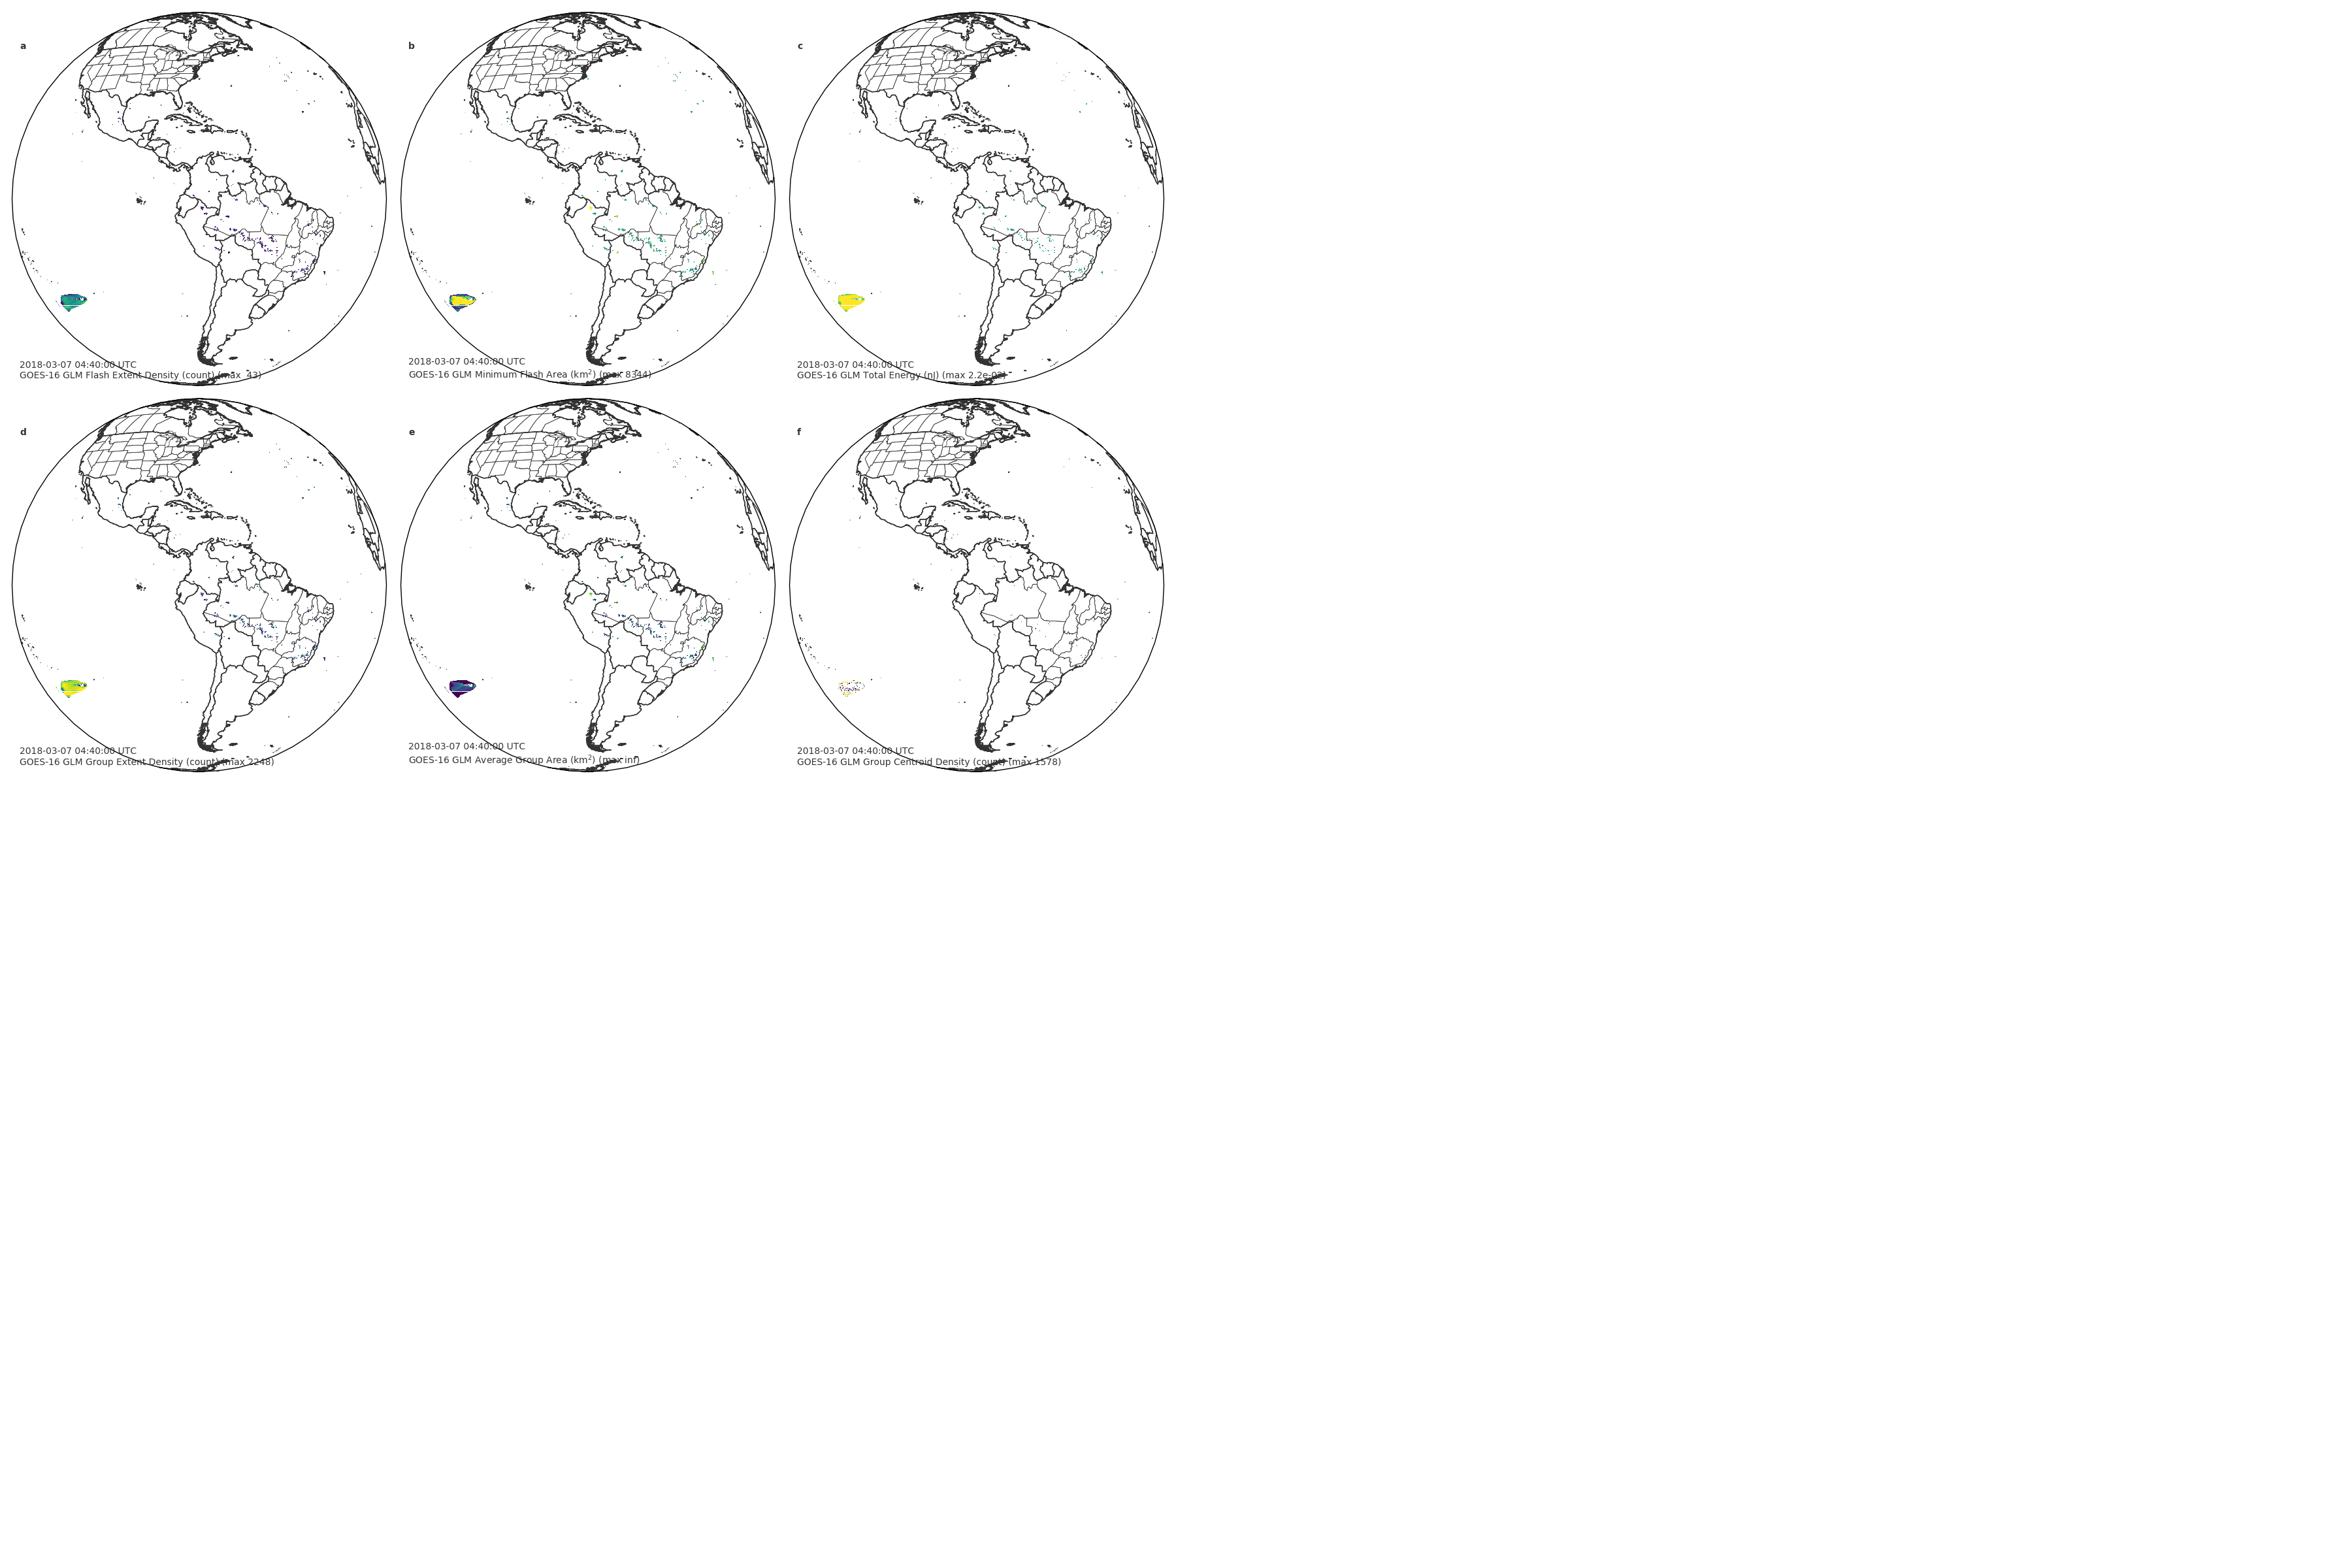

In [5]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# from glmtools.plot.grid import plot_glm_grid
# fig= plt.figure(figsize=(12,8))
# first_time = agglm[{'time_bins':0}]

%matplotlib notebook
import matplotlib.pyplot as plt
from glmtools.plot.grid import plot_glm_grid

fields_6panel = ['flash_extent_density', 'minimum_flash_area','total_energy', 
                 'group_extent_density', 'average_group_area', 'group_centroid_density']


def plot(w, fig=None, time_widget=None, field_widget=None, subplots=(2,3), fields=None):
    t = pd.to_datetime(time_widget.value)
    n_subplots = subplots[0] * subplots[1]
    if fields is None:
        if n_subplots == 1:
            fields = [field_widget.value]
        else:
            fields = fields_6panel[0:n_subplots]

    mapax, cbar_obj = plot_glm_grid(fig, glm_grids, t, fields, subplots=subplots,
                                   axes_facecolor = (1.0, 1.0, 1.0), map_color = (0.2, 0.2, 0.2))


fig = plt.figure(figsize=(18,12))
plt.show()

In [6]:
from ipywidgets import widgets

time_options = [str(t0) for t0 in glm_grids.time.to_series()]
time_options.sort()
field_options = list(k for k in glm_grids.variables.keys() if 'nominal' not in k)
print(field_options)
for v in ['x', 'y', 'time', 'goes_imager_projection']: field_options.remove(v)
field_dropdown = widgets.Dropdown(options=field_options)
time_slider = widgets.SelectionSlider(options=time_options)
glm_select = widgets.HBox([field_dropdown, time_slider])

from functools import partial
plot = partial(plot, fig=fig, field_widget=field_dropdown, time_widget=time_slider)
time_slider.observe(plot)
field_dropdown.observe(plot)

display(glm_select)
plot('yo') # trigger plot since slider won't adjust with only one time.
time_slider.value = time_slider.options[0]

['time', 'y', 'x', 'flash_extent_density', 'flash_centroid_density', 'total_energy', 'group_extent_density', 'group_centroid_density', 'total_flash_area', 'total_group_area', 'average_flash_area', 'average_group_area', 'minimum_flash_area', 'goes_imager_projection']


### Find the time since the last flash

In [8]:

fed_bool = (glm.flash_extent_density > 0.5) # ntimes,ny,nx array
no_fed = (fed_bool.sum(dim='time') < 1)

last_time_idx = fed_bool.argmax(dim='time').compute() # Remove compute if not using dask.
print(last_time_idx.min(), last_time_idx.max())
# glm['time_of_last_flash'] = xr.zeros_like(last_time_idx, dtype=glm.time.dtype)

<xarray.DataArray 'flash_extent_density' ()>
array(0) <xarray.DataArray 'flash_extent_density' ()>
array(2)


In [9]:

# never = xr.DataArray(np.datetime64('1980-11-01T00:00:00'))


# last_time_array = np.zeros_like(last_time_idx, dtype=glm.time.data.dtype)
last_times = glm.time[last_time_idx]
never = xr.ones_like(last_times)
never[:] = np.datetime64('1980-11-01T00:00:00')
now = xr.ones_like(last_times)
now[:] = glm.time[-1].data #np.datetime64('now')

final_times = np.where(no_fed, never, last_times)

last_times[:] = final_times

print(type(never), never.dtype, never.shape)
print(type(last_times), last_times.dtype, last_times.shape)
print(type(no_fed), no_fed.dtype, no_fed.shape)

time_since = now - final_times

# flattened = last_times.data.flatten()
# flattened[no_fed.flatten()] = never
# last_times.shape = no_fed.shape
# glm['time_of_last_flash'][no_fed.data.flatten()] = never

# glm['time_of_last_flash'] = 

<class 'xarray.core.dataarray.DataArray'> datetime64[ns] (5424, 5424)
<class 'xarray.core.dataarray.DataArray'> datetime64[ns] (5424, 5424)
<class 'xarray.core.dataarray.DataArray'> bool (5424, 5424)


<IPython.core.display.Javascript object>


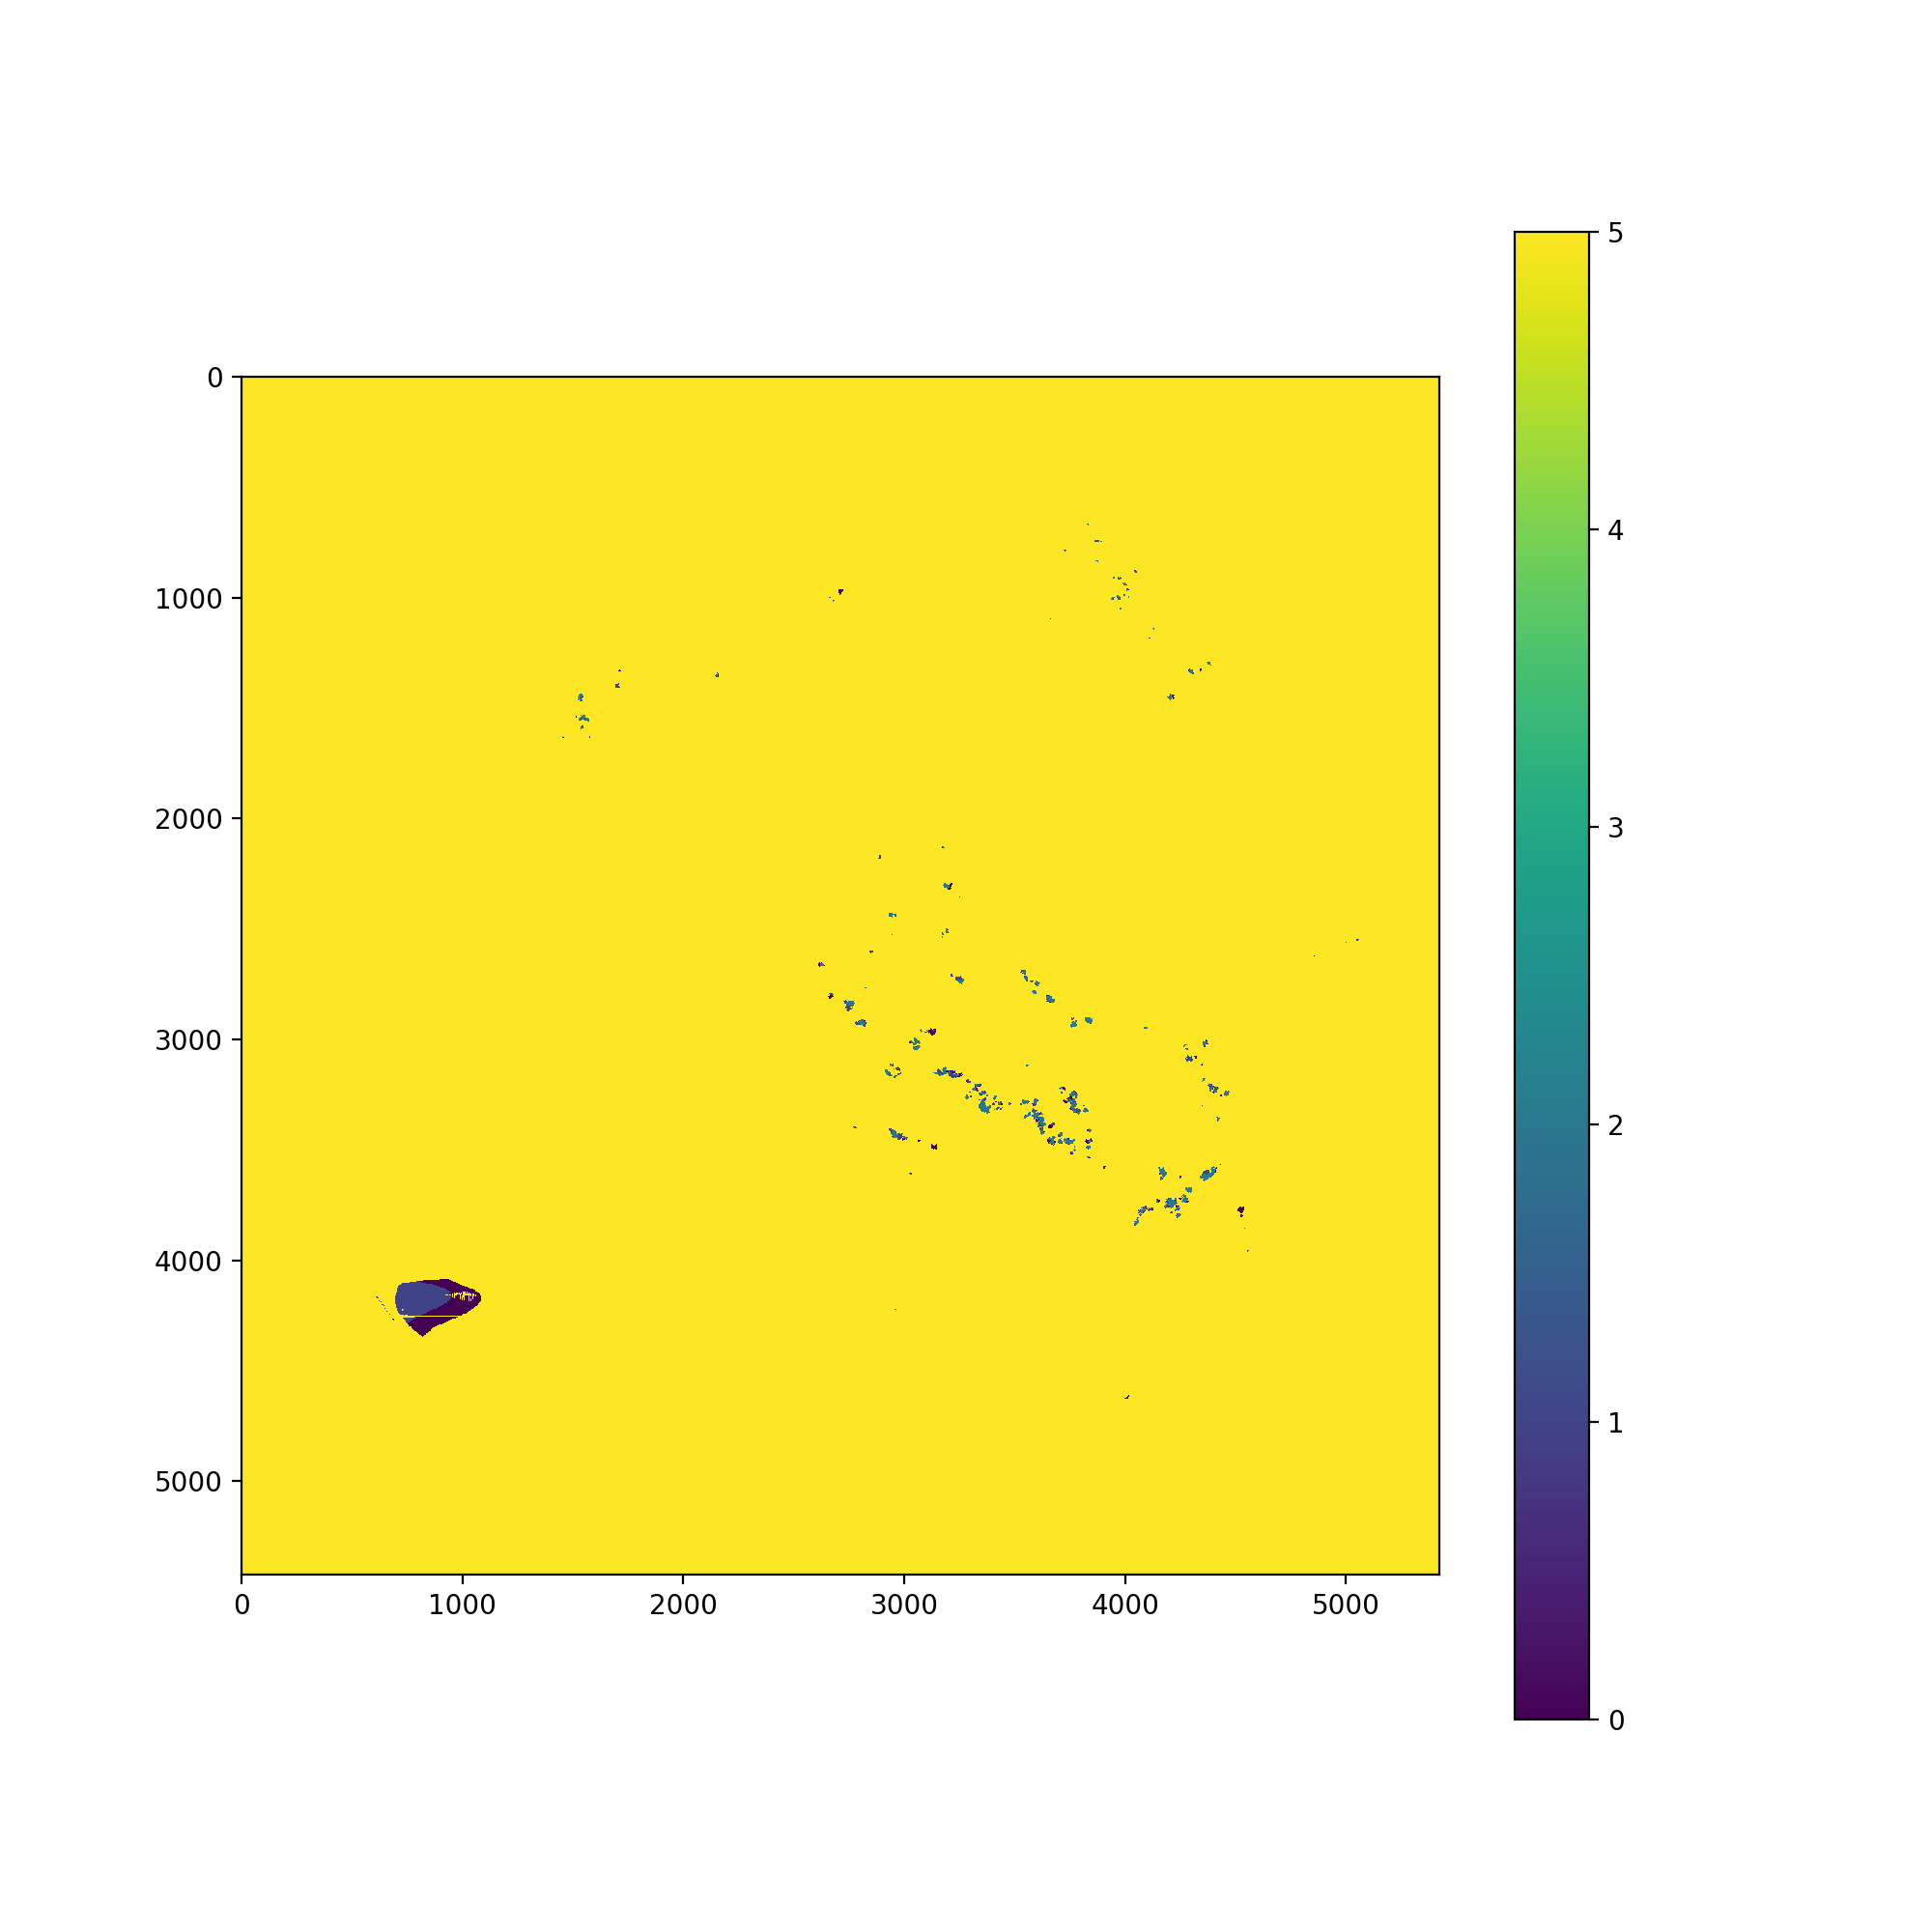

0 minutes 19641882 minutes


In [11]:
plt.figure(figsize=(10,10))
minutes_since = time_since.data.astype('timedelta64[m]')
print(minutes_since.min(), minutes_since.max())

# This is minutes since last flash; areas labled "5" are really much larger … dating back to "never"
plt.imshow(minutes_since.astype(int), vmin=0, vmax=5)
plt.colorbar()